In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

dataset_dir = '/content/drive/MyDrive/flowers-recognition'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

vgg_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False

model = Sequential([
    vgg_model,
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=[early_stopping]
)

_, test_accuracy = model.evaluate(test_generator)
print(f"Точность нейросетевого классификатора: {test_accuracy:.4f}")



# plt.plot(history.history['loss'], label='Потери на обучении')
# plt.plot(history.history['val_loss'], label='Потери на валидации')
# plt.xlabel('Эпоха')
# plt.ylabel('Потери')
# plt.legend()
# plt.show()


Found 200 images belonging to 6 classes.
Found 52 images belonging to 6 classes.
Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.1681 - loss: 2.1109 - val_accuracy: 0.2885 - val_loss: 1.7580
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step - accuracy: 0.2348 - loss: 1.9077 - val_accuracy: 0.2885 - val_loss: 1.7432
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.2976 - loss: 1.7347 - val_accuracy: 0.2885 - val_loss: 1.7354
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.1866 - loss: 1.9023 - val_accuracy: 0.3077 - val_loss: 1.7397
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.2338 - loss: 1.7938 - val_accuracy: 0.2885 - val_loss: 1.7436
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.2898 - loss: 1.7539 - val_accuracy: 0.2885 - val_loss: 1.7379
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.2598 - loss: 1.7057 - val_accuracy: 0.2885 - val_loss: 1.7361
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


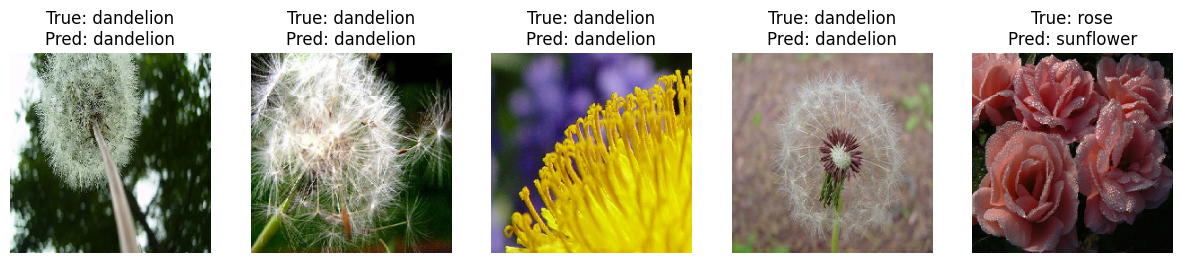

In [22]:
def visualize_predictions(generator, model, n_samples=5):

    imgs, lbls = next(generator)
    preds = model.predict(imgs[:n_samples])
    preds = np.argmax(preds, axis=1)
    true_labels = np.argmax(lbls[:n_samples], axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(imgs[i])
        plt.title(f"True: {list(generator.class_indices.keys())[true_labels[i]]}\n"
                  f"Pred: {list(generator.class_indices.keys())[preds[i]]}")
        plt.axis('off')
    plt.show()

visualize_predictions(test_generator, model, n_samples=5)
